# Modules

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import urllib.request
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, StrMethodFormatter
import matplotlib

from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

sys.path.append('..')
from src import config, data

plt.rcParams.update(plt.rcParamsDefault)
plt.style.use(['ggplot', 'bmh'])
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)

display_settings = {
    'max_columns': 999,
    'expand_frame_repr': True,
    'max_rows': 999,
    'precision': 4,
    'show_dimensions': True
}

for op, value in display_settings.items():
    pd.set_option("display.{}".format(op), value)


%matplotlib inline

# Data

In [213]:
data.consolidate_dataset()

In [214]:
df = pd.read_csv(
    config.get_processed_filename(config.DATA_FILES['order'])
)

df[config.COLUMN_DATE] = df[config.COLUMN_DATE].apply(pd.to_datetime)

df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,product_category_name,seller_zip_code_prefix,seller_city,seller_state,state_name,state_code,lat,long
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,47813,barreiras,BA,1,boleto,1,141.46,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,4,perfumery,31570.0,belo horizonte,SP,Bahia,BA,-12.5200,-41.6900
1,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,75265,vianopolis,GO,1,credit_card,3,179.12,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.9,19.22,5,auto,14840.0,guariba,SP,Goiás,GO,-15.9333,-50.1333
2,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,9195,santo andre,SP,1,credit_card,1,28.62,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.9,8.72,5,stationery,8752.0,mogi das cruzes,SP,SãoPaulo,SP,-23.5333,-46.6333
3,82566a660a982b15fb86e904c8d32918,d3e3b74c766bc6214e0c830b17ee2341,delivered,2018-06-07 10:06:19,2018-06-09 03:13:12,2018-06-11 13:29:00,2018-06-19 12:05:52,2018-07-18,35400,ouro preto,MG,1,boleto,1,50.13,1.0,72a97c271b2e429974398f46b93ae530,094ced053e257ae8cae57205592d6712,2018-06-18 03:13:12,31.9,18.23,5,perfumery,14095.0,ribeirao preto,SP,MinasGerais,MG,-19.8167,-43.9500
4,5ff96c15d0b717ac6ad1f3d77225a350,19402a48fe860416adf93348aba37740,delivered,2018-07-25 17:44:10,2018-07-25 17:55:14,2018-07-26 13:16:00,2018-07-30 15:52:25,2018-08-08,4812,sao paulo,SP,1,credit_card,3,32.70,1.0,10adb53d8faa890ca7c2f0cbcb68d777,1900267e848ceeba8fa32d80c1a5f5a8,2018-07-27 17:55:14,19.9,12.80,5,bed_bath_table,14940.0,ibitinga,SP,SãoPaulo,SP,-23.5333,-46.6333


In [217]:
s = 34322.453
f'{s:,.0f}'

'34,322'

In [215]:
df.groupby(['customer_state', 'state_name', pd.Grouper(key='order_purchase_timestamp', freq='1M')])['payment_value'].sum().reset_index()

,customer_state,state_name,order_purchase_timestamp,payment_value
0,AC,Acre,2018-01-31,1157.89
1,AC,Acre,2018-02-28,299.22
2,AC,Acre,2018-03-31,164.67
3,AC,Acre,2018-04-30,588.17
4,AC,Acre,2018-05-31,1501.42
5,AC,Acre,2018-06-30,597.26
6,AC,Acre,2018-07-31,5002.15
7,AC,Acre,2018-08-31,604.52
8,AL,Alagoas,2018-01-31,7329.14
9,AL,Alagoas,2018-02-28,6125.35


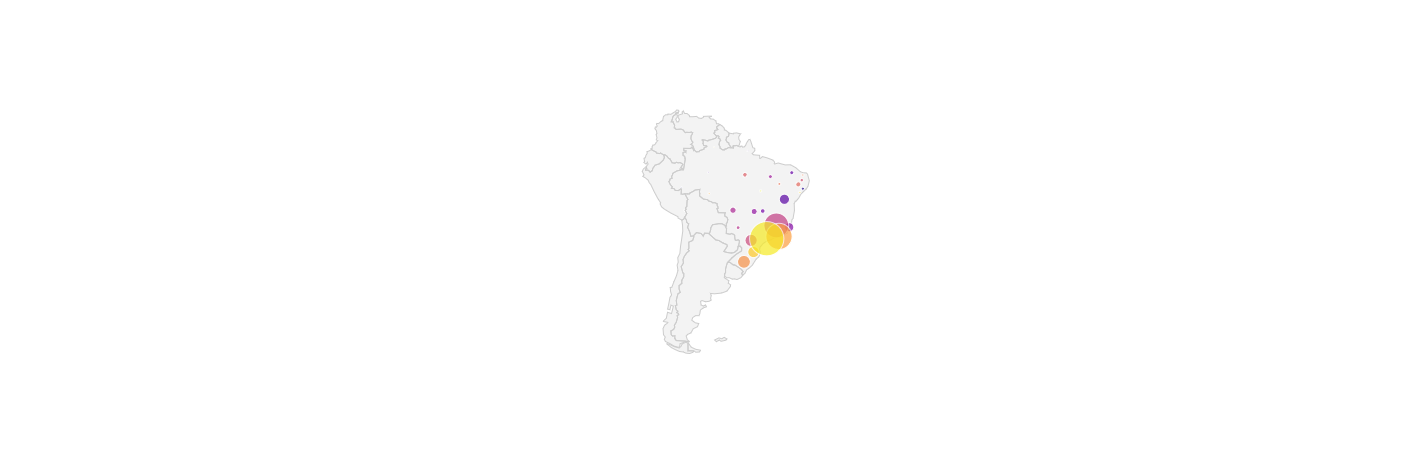

In [210]:
dff = df.groupby(['customer_state', 'state_name', 'lat', 'long'])['payment_value'].sum().reset_index()
dff['text'] = dff['state_name'] + ": " + dff['payment_value'].apply(lambda x: f"R$ {x:,.0f}")

fig = go.Figure(
    go.Scattergeo(
        lat=dff['lat'], 
        lon=dff['long'],
        text=dff['text'],
        marker = dict(
            size = dff['payment_value'] / 1e6,
            sizemode = 'area',
            color=dff['state_name'].astype('category').cat.codes
        ),
    )
)

fig.update_layout(
    showlegend = False,
    geo = dict(
        scope = 'south america',
        projection_type = 'equirectangular',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)